<a href="https://colab.research.google.com/github/AlekseiMikhalev/Data-Science-Projects/blob/master/ULMFiT_Twitter%20Sentiment%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook has been created for participation in Fellowship.ai challenge. 

In [0]:
# Environment setup. Importing the libraries.
import re
from functools import partial
from collections import Counter
import string
import pandas as pd
from fastai import *
from fastai.text import *
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas
from sklearn.model_selection import train_test_split
import numpy

Importing dataset and doing data pre-processing

In [70]:
# Import the file with dataset and read the first five rows to get the overview of the dataset
tweet = pd.read_csv("/content/Tweets.csv")
tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [71]:
# Explore the number of each feature
tweet.count()

tweet_id                        14640
airline_sentiment               14640
airline_sentiment_confidence    14640
negativereason                   9178
negativereason_confidence       10522
airline                         14640
airline_sentiment_gold             40
name                            14640
negativereason_gold                32
retweet_count                   14640
text                            14640
tweet_coord                      1019
tweet_created                   14640
tweet_location                   9907
user_timezone                    9820
dtype: int64

We need to preprocess our dataset and transform it into the dataset which is appropriate for further use with ULMFiT. Our new dataset should contain label and text columns.

In [72]:
# Removing needless columns and create a new dataset 
new_tweet = tweet[['airline_sentiment','text']]
new_tweet.head()


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [0]:
# Save new DataFrame into csv file for the fast.ai processing
new_tweet.to_csv(r'/content/new_tweet.csv')

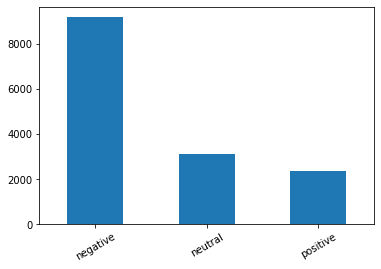

In [74]:
# Plot value counts for each label in the dataset
new_tweet['airline_sentiment'].value_counts().plot.bar(rot=30)

Cleaning and pre-processing the data for modelling

In [75]:
# Clean the data for modelling 
# Retaining only alphabets and removing everything else
new_tweet['text'] = new_tweet['text'].str.replace("[^a-zA-Z]", " ")
new_tweet.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,airline_sentiment,text
0,neutral,VirginAmerica What dhepburn said
1,positive,VirginAmerica plus you ve added commercials t...
2,neutral,VirginAmerica I didn t today Must mean I n...
3,negative,VirginAmerica it s really aggressive to blast...
4,negative,VirginAmerica and it s a really big bad thing...


In [0]:
# split data into training and validation set
train, test = train_test_split(new_tweet, test_size=0.4)

In [77]:
train.shape, test.shape

((8784, 2), (5856, 2))

In [0]:
# Define the path for train and test data
path = Path('/content/')
train.to_csv(path/'train.csv', index=False, header=False)
test.to_csv(path/'test.csv', index=False, header=False)

In [79]:
train.head()

,airline_sentiment,text
6054,positive,I appreciate the reply RT SouthwestAir lux...
3542,neutral,united done as requested
8450,neutral,JetBlue Can you tell me which days you fly di...
11082,negative,USAirways delayed further
14434,negative,AmericanAir there was also not one single per...


In [80]:
test.head()

,airline_sentiment,text
4370,positive,SouthwestAir THANK YOU for your awesome flig...
14168,negative,AmericanAir ah if only we could get through ...
310,neutral,VirginAmerica missed my flight How does stan...
2695,neutral,united I have a question about my interview p...
3705,negative,united idea if u don t want us to be frustra...


In [0]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'train.csv', min_freq=1)

In [0]:
# Save the language model data for re-use
data_lm.save()

In [83]:
data_lm.show_batch()

idx,text
0,xxmaj not scheduled to get xxup pu unt aft xxup why u shld b ashamed i m disgusted w u xxbos jetblue thank you for being jetblue and not jetgreen or jetred blue is my favorite color and jet blue makes it better xxbos usairways over weeks since you took our money and left us stranded hours from home xxmaj had to rent a car and you still have not
1,sundayfunday xxbos southwestair xxmaj there is no way that i am getting back on a plane with your airline i will be calling to get a refund xxmaj as i drive hrs home xxbos jetblue do you think snow in boston on will effect my flight xxbos xxmaj please explain jetblue xxmaj our fleet s on fleek http t co vosizh sl xxbos united also forgot add our bag is
2,xxup nz xxbos united horrible wait time on to get a gate shows total miss management xxmaj value customer time and respect thier sentiment xxbos united you do realize my wife is waiting on a delayed flight at this very moment i m not sure i understand your tweet xxbos southwestair suggestion shades on the windows kciairport so travelers won t have to watch ur luggage handlers throwing their bags
3,hour xxbos jetblue thank you so much for your effort xxbos united i see you guys are at it again xxmaj amazing how one company continually makes mistakes yet fails to be held accountable for their error xxbos united two years old xxmaj birthdate xxbos americanair xxmaj yes thank you xxmaj just not how i wanted to start my vacation xxbos jetblue thanks for making an effort xxmaj credit where
4,who confirmed are not important frustrated xxbos virginamerica this is great news xxmaj america could start flights to xxmaj hawaii by end of year http t co r p xxmaj zy fe via xxmaj pacificbiznews xxbos jetblue if i had made as many mistakes as you in as short a period of time i would i have lost my job at this point xxbos united you changed my entire flight


In [0]:
# Use the data_lm object we created earlier to fine-tune a pre-trained language model. 
# Creating learner object, ‘learn’, that will directly create a model, download the pre-trained weights, and be ready for fine-tuning:

learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.1)

In [91]:
# Print the structure of the model
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(9008, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(9008, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=9008, bias=True)
   (output_dp): RNNDropout()
 )]

Let's try to find the optimum learning rate


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


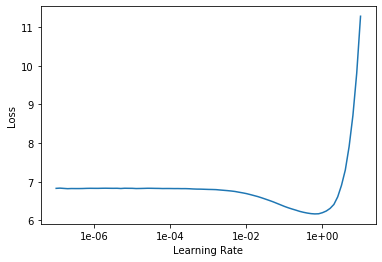

In [92]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [0]:
'''Wow! We got a whopping increase in the accuracy and even the validation loss is far less than the training loss. It is a pretty outstanding performance on a small dataset. You can even get the predictions for the validation set out of the learner object by using the below code:

# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)'''